<a href="https://colab.research.google.com/github/anastaszi/255_datamining/blob/main/HW5_Boost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

a) Showcase  gbm **classifier techniques**
(XGBoost, Catboost, LightGBM, RandomForest, Adaboost, Decision tree classifier)

b) Showcase gradient boost **regression techniques** XGBoost, Catboost, LightGBM

c) showcase gradient boost **ranking techniques** XGBoost, Catboost, LightGBM

# Library Imports

In [1]:
!pip install --upgrade gensim

     |████████████████████████████████| 24.1 MB 3.1 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.3 MB/s 


In [3]:
!pip install contractions

     |████████████████████████████████| 284 kB 5.1 MB/s 
     |████████████████████████████████| 321 kB 39.6 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85450 sha256=f65d13b7115233111fa7097b33cb4de8167c6daf84ba6bfd1ce7894d186e68c6
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [4]:
!pip install nltk

In [5]:
!pip install shap

     |████████████████████████████████| 564 kB 5.0 MB/s 


In [19]:
import numpy as np
import pandas as pd
import re
import pickle
import gensim
import sklearn
import seaborn as sns
import wordcloud
import nltk
import unicodedata
import contractions
from numpy import mean
from contractions import contractions_dict
from gensim.similarities.annoy import AnnoyIndexer
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
from wordcloud import WordCloud, STOPWORDS
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('wordnet')

from time import time
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (RandomForestClassifier,
                              AdaBoostClassifier,
                              GradientBoostingClassifier)
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
tokenizer = ToktokTokenizer()
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from catboost import CatBoostRanker, Pool, MetricVisualizer
import catboost as cb
import shap
shap.initjs()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
from google.colab import drive
drive.mount('/content/gdrive/')

%matplotlib inline

Mounted at /content/gdrive/


# Classifiers

## Data import

Dataset: [Udemy Course Review from Kaggle](https://www.kaggle.com/sabrisangjaya/udemy-course-review?select=udemy+review.csv)

Task: Classify Reviews (bad -> great)

In [ ]:
df_ur = pd.read_csv('/content/gdrive/MyDrive/DataMining/udemy_review.csv', sep=';')

In [ ]:
df_ur.head(1)

course_id  rating                           review_content              date
0       8082     4.5  Delivers more than expected. Thank you!  29/07/2019 11:19

In [ ]:
df_ur.drop(['date', 'course_id'], axis=1, inplace=True)

In [ ]:
df_ur.shape

(488758, 2)

## Data preprossesing

Shuffle and reduce dataframe to first 5 000 reviews.

In [ ]:
df_ur1 = sklearn.utils.shuffle(df_ur, random_state=1000).reset_index(drop=True).copy()

In [ ]:
df_ur1 = df_ur1.head(5000)

In [ ]:
df_ur1.shape

(5000, 2)

In [ ]:
df_ur1['rating'].unique()

array([1. , 2.5, 5. , 4.5, 3.5, 3. , 4. , 2. , 1.5, 0.5])

In [ ]:
df_ur1['rating'] = round(df_ur1['rating']).astype('int').astype('category')

In [ ]:
df_ur1['rating'].unique()

[1, 2, 5, 4, 3, 0]
Categories (6, int64): [1, 2, 5, 4, 3, 0]

In [ ]:
df_ur1.isna().sum()

rating            0
review_content    1
dtype: int64

In [ ]:
df_ur1.dropna(inplace=True)

In [ ]:
df_ur1.isna().sum()

rating            0
review_content    0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


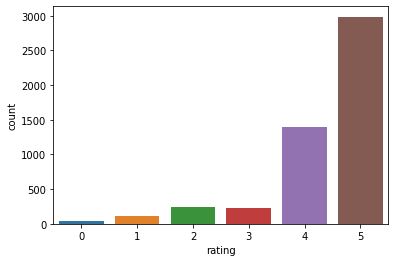

In [ ]:
sns.countplot('rating', data=df_ur1);

In [ ]:
stopword_list=['in','of','at','a','the', 'and', 'for', 'even', 'have', 'this', 'you', 'what', 'will']

In [ ]:
def process_text(text):
    def remove_accented_chars(text):
      text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
      return text

    def remove_stopwords(words, stopwords):
      words = [w for w in  words  if not w in stopwords] 
      return words
    def remove_smallwords(words):
      words = [w for w in  words  if len(w)> 2] 
      return words

    doc = remove_accented_chars(text)
    # remove contractions
    doc = contractions.fix(doc)
    doc = doc.lower()
    # remove new lines
    doc = re.sub(r'[\r|\n|\r\n]+','', doc)
    # remove extra white spaces
    doc = re.sub(' +', ' ', doc)
    # remove special characters
    special_char_pattern = re.compile(r'([{.(-)!}])')
    # leave only words
    doc = re.sub('\W+',' ', doc)
    doc = re.sub(r'[^a-zA-Z\s]', '', doc)
    words = tokenizer.tokenize(doc)
    words = [token.strip() for token in words]
    # lemmatize
    words = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    words = remove_stopwords(words, stopword_list)
    words = remove_smallwords(words)
    return words

In [ ]:
print(stopword_list)

['in', 'of', 'at', 'a', 'the', 'and', 'for', 'even', 'have', 'this', 'you', 'what', 'will']


In [ ]:
df_ur1['words'] = df_ur1['review_content'].apply(process_text)

In [ ]:
df_ur1.head(1)

rating                review_content                   words
0      1  Not promised what was given.  [not, promised, given]

In [ ]:
def cloud(data,rating,backgroundcolor = 'white',  width = 800, height = 600):
  stopwords = set(stopword_list)
  wordcloud = WordCloud(stopwords = stopwords, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
  plt.figure(figsize = (10,5))
  
  plt.imshow(wordcloud)
  plt.axis("off")
  print("Rating: ", rating)
  plt.show()

Rating:  1


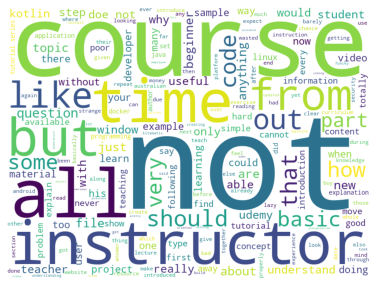

Rating:  2


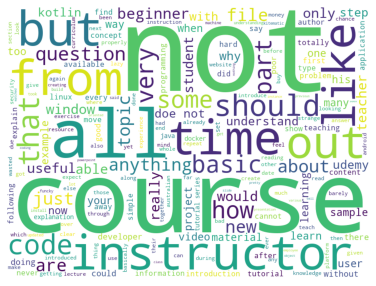

Rating:  5


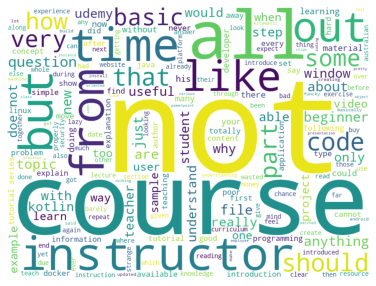

Rating:  4


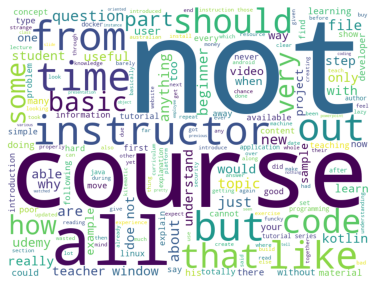

Rating:  3


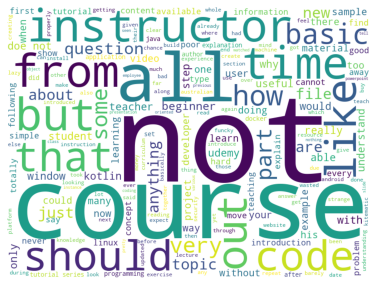

Rating:  0


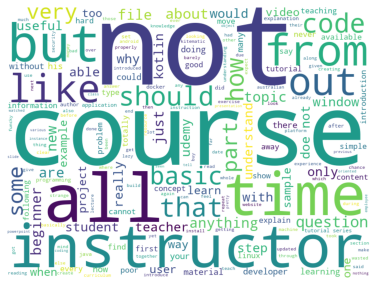

In [ ]:
for rating in list(df_ur1['rating'].unique()):
  cloud(' '.join(df_ur1[df_ur1['rating']==0.0]['words'].apply(lambda x: ' '.join(x))), rating)

In [ ]:
X = df_ur1.drop('rating', axis=1)
y = df_ur1['rating']

In [ ]:
df_ur1.head(1)

rating                review_content                   words
0      1  Not promised what was given.  [not, promised, given]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Preprocessing our data
tfidf = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x)
X_train_tfidf_features = tfidf.fit_transform(X_train['words'])
X_test_tfidf_features = tfidf.transform(X_test['words'])

In [ ]:
X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(X_train_tfidf_features, y_train, test_size=0.1)

In [ ]:
X_train_tfidf_features.shape

(3999, 6268)

In [ ]:
base_estim = DecisionTreeClassifier(max_depth=1, max_features=0.06)
random_state = 2347

## Muller Loop

In [ ]:
classifiers = []
classifiers.append(('Decision Tree', DecisionTreeClassifier(max_depth=12, random_state=1234), True))
classifiers.append(("Random Forest", RandomForestClassifier(n_estimators=500,
                            max_features=0.06,
                            n_jobs=6,
                            random_state=random_state), True))
classifiers.append(("Ada Boost", AdaBoostClassifier(base_estimator=base_estim,
                        n_estimators=500,
                        learning_rate=0.5,
                        random_state=random_state), True))
classifiers.append(("Gradient Boost", GradientBoostingClassifier(n_estimators=2000,
                                 subsample=0.67,
                                 max_features=0.06,
                                 validation_fraction=0.1,
                                 n_iter_no_change=15,
                                 verbose=0,
                                 random_state=random_state), True))
classifiers.append(("Cat Boost", CatBoostClassifier(verbose=0, n_estimators=100), False))

classifiers.append(("LightGBM", LGBMClassifier(n_estimators=2000,
                      feature_fraction=0.06,
                      bagging_fraction=0.67,
                      bagging_freq=1,
                      verbose=0,
                      n_jobs=6,
                      random_state=random_state), False))
classifiers.append(("EXtreme Gradient Boosting", XGBClassifier(n_estimators=2000,
                    tree_method='hist',
                    subsample=0.67,
                    colsample_level=0.06,
                    verbose=0,
                    n_jobs=6,
                    random_state=random_state), False))

In [ ]:
def model_loop(models, X_train, X_test, X_valid, y_train, y_test, y_valid):
  results = []
  for (name, model, isSklearn) in models:
    start_time = time()
    if isSklearn: 
      model.fit(X_train, y_train)
    else:
      model.fit(X_train, y_train, 
                eval_set = [(X_valid, y_valid)],
              early_stopping_rounds=15,
              verbose=0)
    run_time = time() - start_time
    accuracy = model.score(X_test, y_test)
    results.append([name, accuracy, run_time]) 
  return results

In [ ]:
results = model_loop(classifiers, X_train_sub, X_test_tfidf_features, X_valid, y_train_sub, y_test, y_valid)

In [ ]:
df_results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Time'])
df_results

Model  Accuracy       Time
0              Decision Tree     0.599   0.161896
1              Random Forest     0.647  28.770070
2                  Ada Boost     0.586   3.497438
3             Gradient Boost     0.652   2.099222
4                  Cat Boost     0.669  23.974410
5                   LightGBM     0.647   4.035503
6  EXtreme Gradient Boosting     0.630   2.967735

In [ ]:
# added from  https://www.statology.org/seaborn-barplot-show-values/
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.4f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.4f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

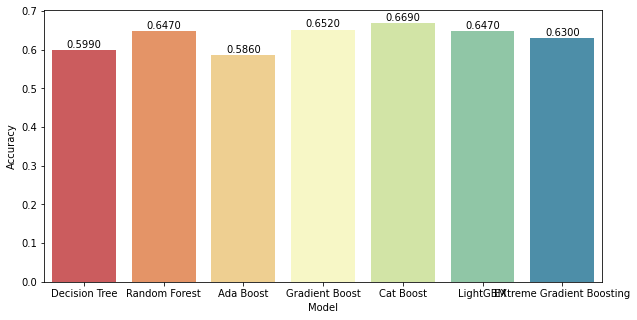

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
p = sns.barplot(x=df_results['Model'], y=df_results['Accuracy'], palette='Spectral')
show_values(p)
plt.show()

# Regressors

## Data import
Data: [Kaggle Car dataset](https://www.kaggle.com/goyalshalini93/car-data)

Task: Car Price prediction

In [ ]:
df_car = pd.read_csv('/content/gdrive/MyDrive/DataMining/CarPrice_Assignment.csv')

In [ ]:
df_car.head(1)

car_ID  symboling             CarName  ... citympg highwaympg    price
0       1          3  alfa-romero giulia  ...      21         27  13495.0

[1 rows x 26 columns]

In [ ]:
df_car.dtypes

car_ID                int64
symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object

In [ ]:
df_car.drop(['car_ID', 'symboling', 'CarName'], axis=1, inplace=True)

In [ ]:
cols=df_car.select_dtypes(exclude=['float64', 'int64']).columns.to_list()
df_car.drop(cols, axis=1, inplace=True)

In [ ]:
df_car.dtypes

wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginesize            int64
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object

In [ ]:
df_car.isnull().sum()

wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginesize          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

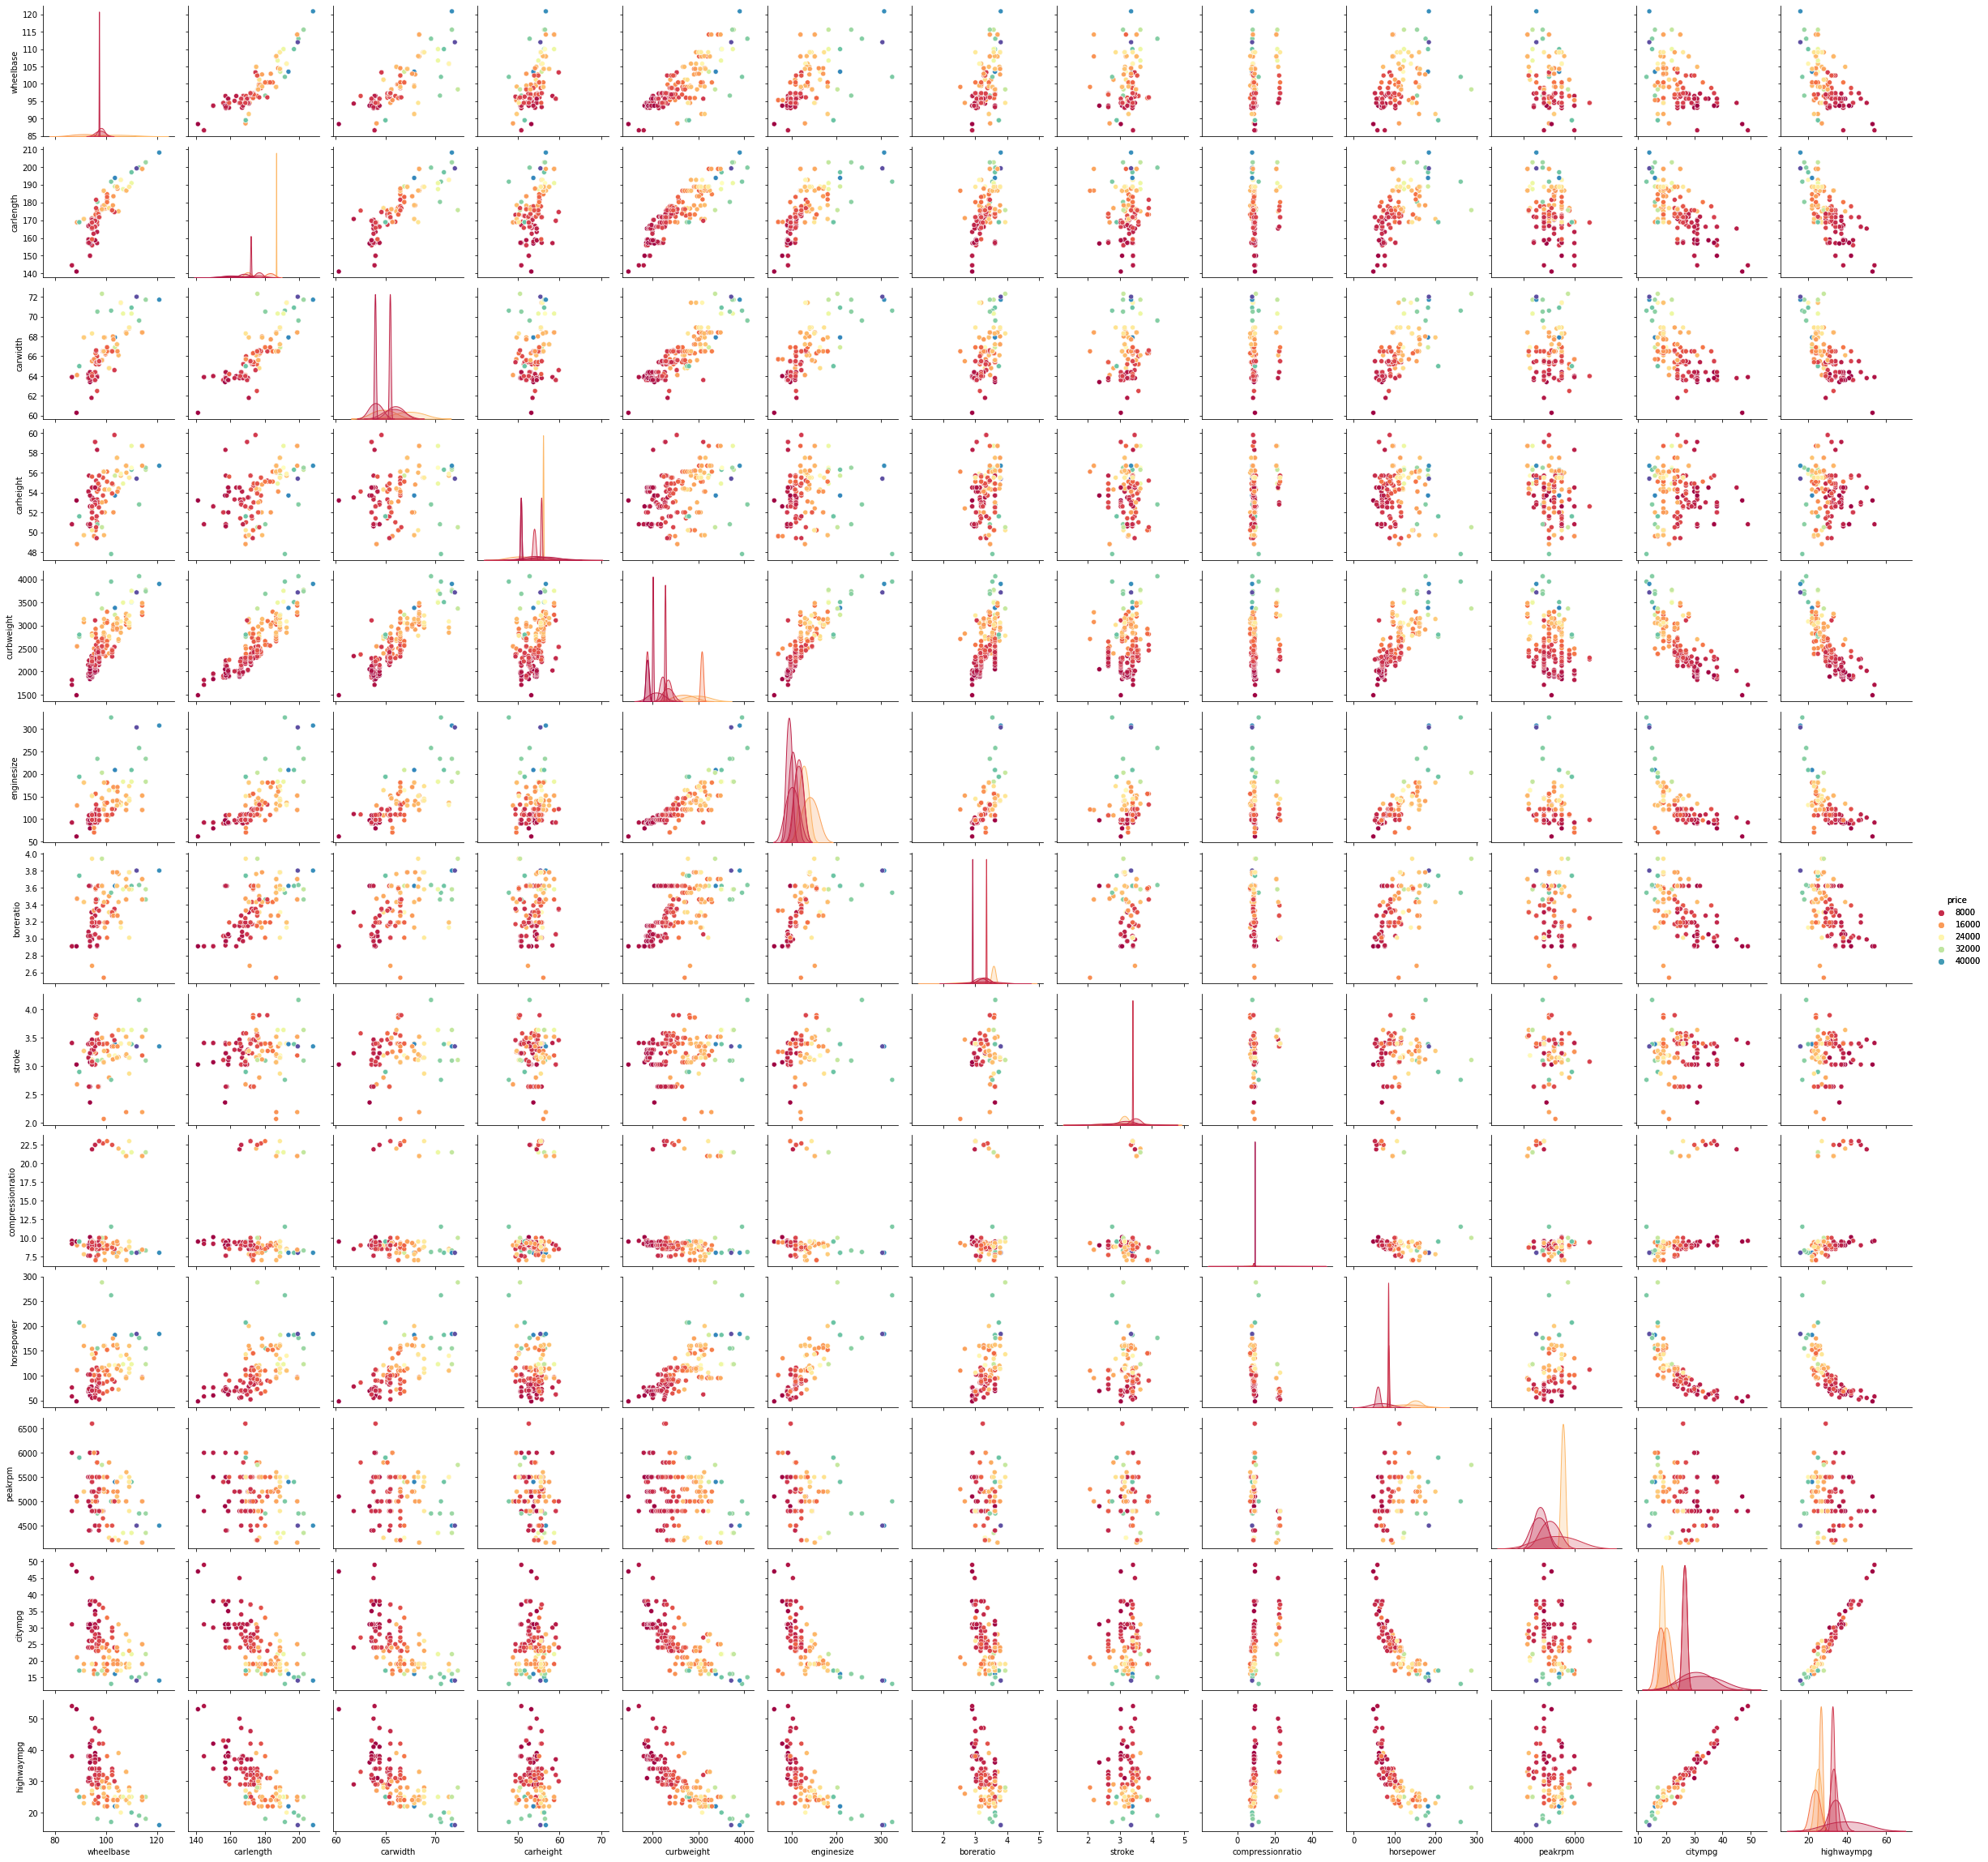

In [ ]:
sns.pairplot(df_car, hue='price',palette='Spectral').add_legend()
plt.show()

## Data preparation

In [ ]:
X_car = df_car.drop('price', axis=1)
y_car = df_car['price']

In [ ]:
X_car_train, X_car_test, y_car_train, y_car_test = train_test_split(X_car, y_car, test_size = 0.2, random_state=5)

In [ ]:
regressors = []
regressors.append(("Cat Boost", cb.CatBoostRegressor(loss_function="RMSE")))
regressors.append(("Light Gradient Boosting", LGBMRegressor()))
regressors.append(("EXtreme Gradient Boosting", XGBRegressor(objective='reg:squarederror')))

In [ ]:
def model_loop_regressors(models, X_train, X_test, y_train, y_test, X, y):
  results = []
  for (name, model) in models:
    start_time = time()
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    model.fit(X_train, y_train, verbose=False)
    run_time = time() - start_time
    print("Model: ", name)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X)
    accuracy = model.score(X_test, y_test)
    results.append([name, mean(n_scores), accuracy, run_time]) 
  return results

Model:  Cat Boost


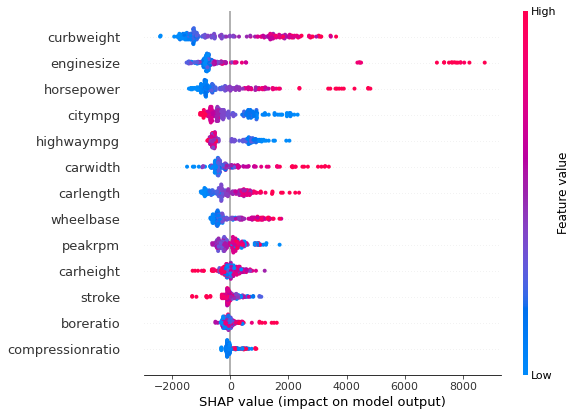

Model:  Light Gradient Boosting


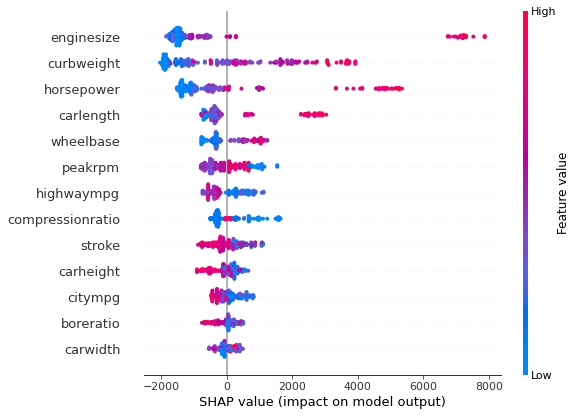

Model:  EXtreme Gradient Boosting


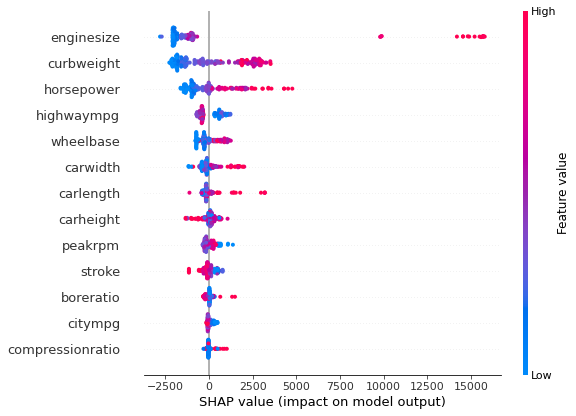

In [ ]:
results_regression = model_loop_regressors(regressors, X_car_train, X_car_test, y_car_train, y_car_test, X_car, y_car)

In [ ]:
df_results_regressors = pd.DataFrame(results_regression, columns=['Model', 'Mean R2 Score', 'Accuracy', 'Time'])
df_results_regressors

Model  Mean R2 Score  Accuracy       Time
0                  Cat Boost       0.913910  0.973650  43.405628
1    Light Gradient Boosting       0.860157  0.954969   0.856735
2  EXtreme Gradient Boosting       0.909520  0.959604   0.772610

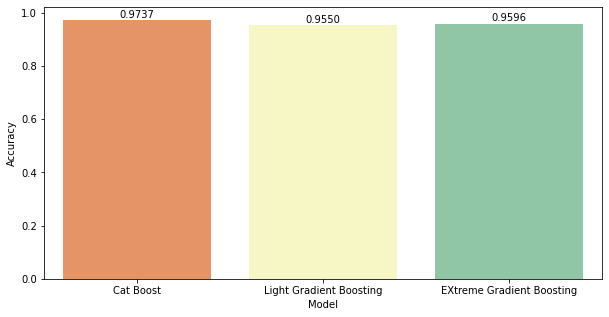

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
p = sns.barplot(x=df_results_regressors['Model'], y=df_results_regressors['Accuracy'], palette='Spectral')
show_values(p)
plt.show()

#Rankings

Data: [Catboost data set]


## Data import

In [8]:
from catboost.datasets import msrank_10k
train_df, test_df = msrank_10k()

X_train = train_df.drop([0, 1], axis=1).values
y_train = train_df[0].values
queries_train = train_df[1].values

X_test = test_df.drop([0, 1], axis=1).values
y_test = test_df[0].values
queries_test = test_df[1].values

In [14]:
print("Number of documents: ", X_train.shape[0])
print("Number of features: ", X_train.shape[1])

Number of documents:  10000
Number of features:  136


In [15]:
from collections import Counter
print("Relevance labels statistics:")
Counter(y_train).items()

Relevance labels statistics:


dict_items([(0.5, 1326), (0.0, 5481), (0.25, 3000), (0.75, 142), (1.0, 51)])

In [16]:
print("For calculation such metrics as NDCG and PFound relevances should be in segment [0,1]:")
max_relevance = np.max(y_train)
y_train /= max_relevance
y_test /= max_relevance

For calculation such metrics as NDCG and PFound relevances should be in segment [0,1]:


In [17]:
num_queries = np.unique(queries_train).shape[0]
print("Number of queries: ", num_queries)

Number of queries:  87


In [20]:
print("Creation of CatBoost pools")
train = Pool(
    data=X_train,
    label=y_train,
    group_id=queries_train
)

test = Pool(
    data=X_test,
    label=y_test,
    group_id=queries_test
)

Creation of CatBoost pools


In [21]:
print("Reducing problem to machine learning task:")
default_parameters = {
    'iterations': 2000,
    'custom_metric': ['NDCG', 'PFound', 'AverageGain:top=10'],
    'verbose': False,
    'random_seed': 0,
}

parameters = {}

Reducing problem to machine learning task:


In [24]:
def fit_model(loss_function, additional_params=None, train_pool=train, test_pool=test):
    parameters = default_parameters.copy()
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function
    
    if additional_params is not None:
        parameters.update(additional_params)
        
    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=test_pool, plot=True)
    
    return model

In [25]:
print("Train the model: ")
model = fit_model('RMSE', {'custom_metric': ['PrecisionAt:top=10', 'RecallAt:top=10', 'MAP:top=10']})


Train the model: 


Regression loss ('RMSE') ignores an important ranking parameter 'group_id'


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [26]:
def create_weights(queries):
    query_set = np.unique(queries)
    query_weights = np.random.uniform(size=query_set.shape[0])
    weights = np.zeros(shape=queries.shape)
    
    for i, query_id in enumerate(query_set):
        weights[queries == query_id] = query_weights[i]
    
    return weights
    

train_weights = Pool(
    data=X_train,
    label=y_train,
    group_weight=create_weights(queries_train),
    group_id=queries_train
)

test_weights = Pool(
    data=X_test,
    label=y_test,
    group_weight=create_weights(queries_test),
    group_id=queries_test
)

fit_model(
    'RMSE', 
    additional_params={'train_dir': 'RMSE_weigths'}, 
    train_pool=train_weights,
    test_pool=test_weights
)

Regression loss ('RMSE') ignores an important ranking parameter 'group_id'


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
fit_model('QueryRMSE')

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

        # # summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

In [27]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

# References

* [𝐶𝑎𝑡𝐵𝑜𝑜𝑠𝑡 𝑇𝑢𝑡𝑜𝑟𝑖𝑎𝑙](https://colab.research.google.com/github/catboost/tutorials/blob/master/python_tutorial.ipynb?authuser=3#scrollTo=kQ3SOeJGNShc)
* [LGBM ](https://medium.com/@am.sharma/lgbm-on-colab-with-gpu-c1c09e83f2af)
* [AdaBoost](https://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/)
* [XGBoost O'Reilly](https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/tree/master/Chapter03)
* [Gradient_Boosting_Scratch](https://github.com/groverpr/Machine-Learning/blob/master/notebooks/01_Gradient_Boosting_Scratch.ipynb)
* [XG Boost code](https://www.kaggle.com/jszymczak/exampe)
* [Boosting Showdown: Scikit-Learn vs XGBoost vs LightGBM vs CatBoost in Sentiment Classification](https://towardsdatascience.com/boosting-showdown-scikit-learn-vs-xgboost-vs-lightgbm-vs-catboost-in-sentiment-classification-f7c7f46fd956)

* [XGBoost Ranking](https://github.com/dmlc/xgboost/blob/master/demo/rank/rank_sklearn.py)
* [CatBoost Ranking](https://colab.research.google.com/github/catboost/tutorials/blob/master/ranking/ranking_tutorial.ipynb)
* [Lightgbm Ranking](https://stackoverflow.com/questions/64294962/how-to-implement-learning-to-rank-using-lightgbm)